# Meta Prompt Generator based on User Requirements

- Author: [Kenny Jung](https://www.linkedin.com/in/kwang-yong-jung)
- Design:
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Case/rag/02-LangGraph-Prompt-Generation.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Case/rag/02-LangGraph-Prompt-Generation.ipynb)


## Overview

This tutorial explains how to create a chatbot that helps users generate prompts. The chatbot first collects requirements from users, then generates prompts based on these requirements and modifies them according to user input. This process is divided into two separate states, with the LLM determining when to transition between states.
 
A graphical representation of this system can be found below.
 
**Key Topics Covered**
 
- **Gather information**: Defining graphs for collecting user requirements
- **Generate Prompt**: Setting up states for prompt generation
- **Define the state logic**: Defining the chatbot's state logic
- **Create the graph**: Creating graphs and storing conversation history
- **Use the graph**: How to use the generated chatbot
 
In this example, we create a chatbot that helps users generate prompts.
 
The chatbot first collects requirements from users, then generates prompts based on these requirements and modifies them according to user input.
 
This process is divided into two separate states, with the LLM determining when to transition between states.
 
A graphical representation of the system can be found below.


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Collecting user requirements](#collecting-user-requirements)
- [Prompt Generation](#prompt-generation)
- [Define state logic](#define-state-logic)
- [Create the graph](#create-the-graph)
- [Run the graph](#run-the-graph)



![](./assets/02-LangGraph-Prompt-Generation-meta-prompt-generator.png)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can check out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langchain_community",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "02-LangGraph-Prompt-Generation",
    }
)

Environment variables have been set successfully.


You can alternatively set `OPENAI_API_KEY` in `.env` file and load it.

[Note] This is not necessary if you've already set `OPENAI_API_KEY` in previous steps.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Collecting user requirements

At first, we define a node that collects user requirements.

In this process, we can request specific information from the user. We request the necessary information from the user until all necessary information is **satisfied**.

In [5]:
from typing import List
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

# System message template for collecting user requirements
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


# Get user message list and combine with system message
def get_messages_info(messages):
    # Combine system message and existing messages for collecting user requirements
    return [SystemMessage(content=template)] + messages


# Data model for defining instructions on how to prompt the LLM
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    # Objective of the prompt
    objective: str
    # List of variables to be passed into the prompt template
    variables: List[str]
    # List of constraints to avoid in the output
    constraints: List[str]
    # List of requirements that the output must adhere to
    requirements: List[str]


# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# Bind PromptInstructions structure
llm_with_tool = llm.bind_tools([PromptInstructions])


# Create a message chain based on state information and call the LLM
def info_chain(state):
    # Get message information from state and combine with system message
    messages = get_messages_info(state["messages"])
    # Call LLM to generate response
    response = llm_with_tool.invoke(messages)
    # Return generated response as message list
    return {"messages": [response]}

## Prompt Generation

Now, we set the state to generate prompts. 

To do this, we need a separate system message and a function to filter all messages before the tool call.

The definition of the meta prompt we use here is as follows.

**Meta Prompt (Meta Prompt) Definition**

Meta Prompt is a concept that refers to **methods or strategies for optimizing prompt design and creation**, which is used to make AI language models more effective and efficient. It goes beyond simply inputting text, **including structured and creative approaches to guide model responses or improve the quality of results**.

**Key Features**

1. **Goal-oriented structure**  
   Meta prompt includes a clear definition of the information you want to achieve and a step-by-step design process for it.

2. **Adaptive design**  
   Consider the model's response characteristics, limitations, and strengths to modify or iteratively optimize the prompt.

3. **Useful prompt engineering**  
   Include conditional statements, guidelines, role instructions, etc. to finely adjust the model's response.

4. **Multilayer approach**  
   Do not stop at a single question, but adopt a method of incrementally refining the answer through sub-questions.


- Reference: [OpenAI Meta Prompt Engineering Guide](https://platform.openai.com/docs/guides/prompt-generation?context=text-out)

In [6]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage

# Define meta prompt for generating prompts (reference OpenAI Meta Prompt Engineering Guide)
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
  - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
  - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
  - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
  - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
  - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}
"""


# Function to get messages for prompt generation
# Only get messages after tool call
def get_prompt_messages(messages: list):
    # Initialize variable to store tool call information
    tool_call = None
    # Initialize list to store messages after tool call
    other_msgs = []
    # Iterate through message list and process tool call and other messages
    for m in messages:
        # If AI message has tool call, store tool call information
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        # Skip ToolMessage
        elif isinstance(m, ToolMessage):
            continue
        # Add messages after tool call to list
        elif tool_call is not None:
            other_msgs.append(m)
    # Combine system message and messages after tool call and return
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs


# Define function for prompt generation chain
def prompt_gen_chain(state):
    # Get prompt messages from state
    messages = get_prompt_messages(state["messages"])
    # Call LLM to generate response
    response = llm.invoke(messages)
    # Return generated response as message list
    return {"messages": [response]}

## Define state logic

We describe the logic for determining the state of the chatbot.

- If the last message is a `tool call`, the chatbot is in the "prompt creator"(`prompt`) state.
- If the last message is not a `HumanMessage`, the user needs to respond next, so the chatbot is in the `END` state.
- If the last message is a `HumanMessage`, the chatbot is in the `prompt` state if there was a `tool call` before.
- Otherwise, the chatbot is in the `info` state.

In [7]:
from langgraph.graph import END


# Define function for determining state
# Get message list from state
def get_state(state):
    messages = state["messages"]
    # If the last message is aAIMessage and has tool call
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        # Return state for adding tool message
        return "add_tool_message"
    # If the last message is not a HumanMessage
    elif not isinstance(messages[-1], HumanMessage):
        # Return end state
        return END
    # Otherwise, return info state
    return "info"

## Create the graph

Now, we can create a graph. We will use `MemorySaver` to save the conversation history.

In [8]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import ToolMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# Define State
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Initialize MemorySaver for saving conversation history
memory = MemorySaver()

# Initialize state graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)


# Define node for adding tool message
@workflow.add_node
def add_tool_message(state: State):
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0][
                    "id"
                ],  # Get tool call ID from state and add to message
            )
        ]
    }


# Define conditional state transition
workflow.add_conditional_edges("info", get_state, ["add_tool_message", "info", END])

# Define edges
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

# Compile graph
graph = workflow.compile(checkpointer=memory)

Visualize the graph.

https://langchain-ai.github.io/langgraph/how-tos/visualization/?h=visuali#setup

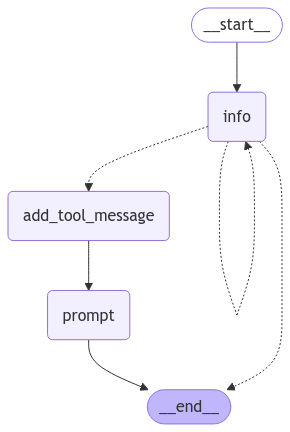

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run the graph

Now, we can run the graph to generate prompts.

In [10]:
import uuid
from langchain_core.messages import HumanMessage

# Initialize configuration with unique thread_id
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Start infinite loop
while True:
    try:
        # Get user input
        user_input = input("User (q/Q to quit): ")
    except EOFError:
        break

    # Print user input
    print(f"\n\033[93m[User] {user_input}\033[0m")

    # If user input is 'q' or 'Q', break the loop
    if user_input.lower() == "q":
        print("AI: See you next time!")
        break

    # Create a state with the user's message
    state = {"messages": [HumanMessage(content=user_input)]}

    # Process the graph with the current state
    result = graph.invoke(state, config=config)  # Use invoke() instead of run()

    # Print the AI's response
    for message in result["messages"]:
        print(f"\033[94m[AI] {message.content}\033[0m")


[User] I need a biz trip plan to SF from Feb 1 to 3. This is for a meeting with partner ABC on 2nd.
[AI] I need a biz trip plan to SF from Feb 1 to 3. This is for a meeting with partner ABC on 2nd.
[AI] To help you create a prompt template for your business trip plan, I need a bit more information:

1. **What is the objective of the prompt?** (e.g., to create a detailed itinerary, suggest places to stay, etc.)
2. **What variables will be passed into the prompt template?** (e.g., dates, location, meeting details, etc.)
3. **Are there any constraints for what the output should NOT do?** (e.g., avoid suggesting certain types of accommodations, etc.)
4. **What requirements must the output adhere to?** (e.g., must include transportation options, must be within a certain budget, etc.)

Please provide these details so I can assist you better!

[User] need to create itinerary, with variable meeting location, constraint for mid-level accommodation, under budget $3,000
[AI] I need a biz trip pl